In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA
import pickle


def generate_data(n_inliers, n_outliers, d,k):
    """
    Generates a synthetic dataset with inliers and outliers,
    embedded in a space of dimension D = d + k, and returns the normalized data.
    
    Parameters:
    -----------
    n_inliers : int
        Number of inlier points.
    n_outliers : int
        Number of outlier points.
    d : int
        Intrinsic dimensionality of the inlier data.
        
    Returns:
    --------
    data_normalized : np.ndarray
        The concatenated dataset (inliers and outliers) after normalization.
        Shape: (n_inliers + n_outliers, d+1)
    """
    
    
    #D = d + 1
    D = d + k

    
    A = np.random.randn(D, D)
    A1 = np.random.randn(D, D)
    Q, _ = np.linalg.qr(A)
    #Q = np.eye(D)
    Q1, _ = np.linalg.qr(A1)

    
    P_inlier = Q[:, :d]  # shape: (D, d)
    #P_outlier = Q1[:, d]
    P_outlier = Q1[:, :k]# shape: (D,k)

   
    inliers = np.random.randn(n_inliers, d)
    inliers_embedded = inliers @ P_inlier.T

    
    outliers = np.random.randn(n_outliers, k)
    #noise = np.random.randn(n_outliers,1)
    #outliers = outliers + 0*noise
    outliers_embedded = outliers @ P_outlier.T

    
    data = np.concatenate([inliers_embedded, outliers_embedded], axis=0)

    
    norms = np.linalg.norm(data, axis=1, keepdims=True)
    data_normalized = data / norms
    
    return data, P_inlier


def generate_data2(n_inliers=100, n_outliers=20, d=3):
   
    D = 2*d                             


    Q, _      = np.linalg.qr(np.random.randn(D, D))
    P_inlier  = Q[:, :d]                   # (D, d)
    P_orth    = Q[:, d:]                   # (D, D-d)

    inliers = np.random.randn(n_inliers, d) @ P_inlier.T      

    cov      = np.random.randn(D, D)                           
    outliers = np.random.randn(n_outliers, D) @ cov.T         

    data = np.vstack([inliers, outliers])                     


    norms = np.linalg.norm(data, axis=1, keepdims=True)
    data  = data / norms

    return data, P_inlier, P_orth

In [2]:
def FMS_dc(X, dd,gamma):
    
    D, N = X.shape
    iter_count = 1
    tol=1e-12 
    max_iter=200
    
    U, _, _ = np.linalg.svd(X, full_matrices=False)
    L = U[:, :dd]
    


    residual = (np.eye(D) - L @ L.T) @ X
    distances = np.sqrt(np.sum(residual**2, axis=0))
    epsilon0 = np.quantile(distances, gamma)

    L_intermediate = {}
    

 
    ang = 1

    for iter_count in range(1, max_iter + 1):
        L_old = L

        # Residual projection onto the orthogonal complement of L
        residual = (np.eye(D) - L_old @ L_old.T) @ X
        distances = np.sqrt(np.sum(residual**2, axis=0))
        
        # Update smoothing parameter: dynamic update based on the gamma-th quantile.
        q_gamma_val = np.quantile(distances, gamma)
        epsilon = min(epsilon0, q_gamma_val)
        
        w = np.maximum(epsilon, distances)
       
        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T

        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        # Compute convergence metric using your subspace_angles function
        ang = np.linalg.norm(subspace_angles(L, L_old))

        L_intermediate[iter_count] = L.copy()

        iter_count += 1

    return L

def FMS(X, dd):
    D, N = X.shape

    # Initial iteration count
    iter = 1

    # Perform SVD and initialize L
    U, _, _ = np.linalg.svd(X, full_matrices=False)
    L = U[:, :dd]

    # Set initial angle and tolerance
    ang = 1
    max_iter = 200
    #while ang > 1e-12 and iter < 1000:
    for iter_count in range(1, max_iter + 1):
        Lold = L

        # Compute the residual projection
        temp = (np.eye(D) - L @ L.T) @ X
        w = np.sqrt(np.sum(temp**2, axis=0)) + 1e-10  #regularization max{mu, ...}, small,large,dynamic smoothing
 
        # Reweight and update XX
        XX = X @ np.diag(1.0 / w) @ X.T

        # Perform SVD again on the weighted matrix XX
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        # Compute the angle between new and old subspace
        ang = np.linalg.norm(subspace_angles(L, Lold))

        iter += 1

    return L

def FMS2(X, dd):
    D, N = X.shape

    # Initial iteration count
    iter = 1

    # Perform SVD and initialize L
    U, _, _ = np.linalg.svd(X, full_matrices=False)
    L = U[:, :dd]

    # Set initial angle and tolerance
    ang = 1
    max_iter = 200
    #while ang > 1e-12 and iter < 1000:
    for iter_count in range(1, max_iter + 1):
        Lold = L

        # Compute the residual projection
        temp = (np.eye(D) - L @ L.T) @ X
        w = np.sqrt(np.sum(temp**2, axis=0)) + 1e-15  #regularization max{mu, ...}, small,large,dynamic smoothing
 
        # Reweight and update XX
        XX = X @ np.diag(1.0 / w) @ X.T

        # Perform SVD again on the weighted matrix XX
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        # Compute the angle between new and old subspace
        ang = np.linalg.norm(subspace_angles(L, Lold))

        iter += 1

    return L

def m_estimator(X):
    N, D = X.shape
    initcov = np.eye(D)  
    oldcov = initcov - 1
    cov = initcov
    iter_count = 1
    eps = 1e-10 
    max_iter = 200 

    #while np.linalg.norm(oldcov - cov, 'fro') > 1e-12 and iter_count < 1000:
    for iter_count in range(1, max_iter + 1):
        temp = X @ np.linalg.inv(cov + eps * np.eye(D))  
        d = np.sum(temp * np.conjugate(X), axis=1)  
        oldcov = cov

       
        temp = (np.real(d) + eps * np.ones(N))**(-1)  
 
        cov = (X.T * temp) @ X / N * D
        cov = cov / np.trace(cov)  
        iter_count += 1  

    return cov


def my_RANSAC(X, d, tau, maxit):
    """
    Runs a RANSAC-like procedure to select an orthonormal basis Ustar that 
    minimizes projection error on a subset of points in X.

    Parameters:
    -----------
    X : numpy.ndarray
        Data matrix of shape (N, D), where each row is a data point.
    d : int
        Dimensionality of the inlier subspace.
    tau : float
        Threshold used to count a point as an inlier (distance below tau).
    maxit : int
        Number of iterations to run RANSAC.

    Returns:
    --------
    Ustar : numpy.ndarray
        Orthonormal basis for the best inlier subspace found (shape (D, d)).
    max_con_num : int
        The maximum number of inliers found.
    """

    N, D = X.shape
    max_con_num = 1
    
    Q, _ = np.linalg.qr(np.random.randn(D, d))
    Ustar = Q

   
    for iter_idx in range(maxit):
        
        indices = np.random.choice(N, d, replace=False)
        
        candidate = X[indices, :].T
        Q_candidate, _ = np.linalg.qr(candidate)
        U = Q_candidate  

        residual = X - (X @ U) @ U.T
        
        dists = np.sqrt(np.sum(residual**2, axis=1))
        
        con_num = np.sum(dists < tau)

        
        if con_num > max_con_num:
            Ustar = U
            max_con_num = con_num

    return Ustar, max_con_num

#add PCA

def STE(X,dd):
    D,N  = X.shape
    initcov = np.eye(D)  
    oldcov = initcov - 1
    cov = initcov
    iter_count = 1
    eps = 1e-10 
    lam = 2
    max_iter = 200

    for iter_count in range(1, max_iter + 1):
        oldcov = cov
        temp = (X.T @ np.linalg.inv(cov + eps * np.eye(D))) * X.T
        w = 1 / (np.sum(temp, axis=1) + eps)
        cov = X @ (w[:, None] * X.T) / N * D

     
        U, S, Vt = np.linalg.svd(cov)
        S1 = np.real(S)
        if dd is not None:
            S1[dd:] = np.mean(S1[dd:]) / lam
        cov = U @ np.diag(S1) @ U.T

        
        cov = cov / np.trace(cov)


    return cov

In [39]:
repeats = 100
d = 10
k = 1
N_total = 160  
outlier_pcts = np.arange(25, 70, 5)
results = {}

for pct in outlier_pcts:
    ratio = pct / 100.0
    num_outliers = int(N_total * ratio)
    num_inliers = N_total - num_outliers

    errors_PCA = []
    errors_FMS = []
    errors_FMSDS = []
    errors_FMSDS2 = []
    errors_TME = []
    errors_STE = []
    errors_RANSAC = []

    for trial in range(repeats):
        # Generate data with a fixed total number of points and varying outlier ratio
        data, P_true= generate_data(n_inliers=num_inliers, n_outliers=num_outliers, d=d,k=k)
        
        # PCA
        pca = PCA(n_components=d)
        pca.fit_transform(data)
        P_PCA = np.array(pca.components_).T  

        # FMS_small 
        P_FMS = FMS(data.T, d)  
        #FMS-DS
        P_FMSDS = FMS_dc(data.T,d,0.5)
        
        P_FMSDS2 = FMS_dc(data.T,d,0.1)

        # TME
        cov = m_estimator(data)
        U, S, VT = np.linalg.svd(cov, full_matrices=False)
        P_TME = VT[:d].T

        # STE
        cov2= STE(data.T, d)
        U, S, VT2 = np.linalg.svd(cov2, full_matrices=False)
        P_STE = VT2[:d].T

        # RANSAC estimation
        P_RAN, _ = my_RANSAC(data, d, tau=1e-7, maxit=200)

        # Subspace errors
        error_PCA    = np.linalg.norm(P_PCA @ P_PCA.T - P_true @ P_true.T)
        error_FMS    = np.linalg.norm(P_FMS @ P_FMS.T - P_true @ P_true.T)
        error_FMSDS    = np.linalg.norm(P_FMSDS @ P_FMSDS.T - P_true @ P_true.T)
        error_FMSDS2    = np.linalg.norm(P_FMSDS2 @ P_FMSDS2.T - P_true @ P_true.T)
        error_TME    = np.linalg.norm(P_TME @ P_TME.T - P_true @ P_true.T)
        error_STE    = np.linalg.norm(P_STE @ P_STE.T - P_true @ P_true.T)
        error_RANSAC = np.linalg.norm(P_RAN @ P_RAN.T - P_true @ P_true.T)

        errors_PCA.append(error_PCA)
        errors_FMS.append(error_FMS)
        errors_FMSDS.append(error_FMSDS)
        errors_FMSDS2.append(error_FMSDS2)
        errors_TME.append(error_TME)
        errors_STE.append(error_STE)
        errors_RANSAC.append(error_RANSAC)

    # Store average errors for current outlier percentage
    results[pct] = {
        "all_PCA":    errors_PCA,
        "all_FMS":    errors_FMS,
        "all_FMSDS":  errors_FMSDS,
        "all_FMSDS2":  errors_FMSDS2,
        "all_TME":    errors_TME,
        "all_STE":    errors_STE,
        "all_RANSAC": errors_RANSAC,
    }
    
with open(f'exp1_errors_d{d}_k{k}.pkl', 'wb') as f:
    pickle.dump(results, f)

In [40]:
#d=3
#k=5
with open(f'exp1_errors_d{d}_k{k}.pkl', 'rb') as f:
    results = pickle.load(f)

outlier_pcts = sorted(results.keys())

err_PCA    = [results[p]["all_PCA"]    for p in outlier_pcts]
err_FMS    = [results[p]["all_FMS"]    for p in outlier_pcts]
err_FMSDS  = [results[p]["all_FMSDS"]  for p in outlier_pcts]
err_FMSDS2  = [results[p]["all_FMSDS2"]  for p in outlier_pcts]
err_TME    = [results[p]["all_TME"]    for p in outlier_pcts]
err_STE    = [results[p]["all_STE"]    for p in outlier_pcts]
err_RANSAC = [results[p]["all_RANSAC"] for p in outlier_pcts]


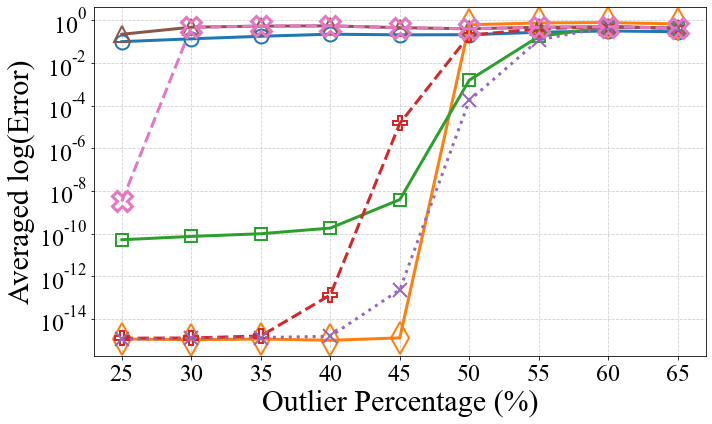

In [6]:
from scipy.stats import gmean
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import numpy as np
d=3
k=1
# Font settings
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman', 'STIXGeneral', 'DejaVu Serif']
mpl.rcParams['mathtext.fontset'] = 'cm'

# Load results
with open(f'exp1_errors_d{d}_k{k}.pkl', 'rb') as f:
    results = pickle.load(f)

outlier_pcts = sorted(results.keys())

# Extract error lists
err_PCA     = [results[p]["all_PCA"]    for p in outlier_pcts]
err_FMS     = [results[p]["all_FMS"]    for p in outlier_pcts]
err_FMSDS1  = [results[p]["all_FMSDS"]  for p in outlier_pcts]    # gamma = 0.5
err_FMSDS2  = [results[p]["all_FMSDS2"] for p in outlier_pcts]    # gamma = 0.1
err_TME     = [results[p]["all_TME"]    for p in outlier_pcts]
err_STE     = [results[p]["all_STE"]    for p in outlier_pcts]
err_RANSAC  = [results[p]["all_RANSAC"] for p in outlier_pcts]

# Compute geometric means
geo_PCA     = gmean(err_PCA,    axis=1)
geo_FMS     = gmean(err_FMS,    axis=1)
geo_FMSDS1  = gmean(err_FMSDS1, axis=1)
geo_FMSDS2  = gmean(err_FMSDS2, axis=1)
geo_TME     = gmean(err_TME,    axis=1)
geo_STE     = gmean(err_STE,    axis=1)
geo_RANSAC  = gmean(err_RANSAC, axis=1)

# Plot
plt.figure(figsize=(10, 6))

plt.plot(outlier_pcts, geo_PCA,     marker='o', markerfacecolor='none',markeredgewidth=2, linewidth=3, markersize=14, label='PCA')
plt.plot(outlier_pcts, geo_RANSAC,  marker='d', markerfacecolor='none',markeredgewidth=2, linewidth=3, markersize=22, label='RANSAC')
plt.plot(outlier_pcts, geo_FMS,     marker='s', markerfacecolor='none',markeredgewidth=2, linewidth=3, markersize=12, label='FMS ($\\epsilon=10^{-10}$)')
plt.plot(outlier_pcts, geo_FMSDS1,  'P--', markerfacecolor='none',markeredgewidth=2, linewidth=3, markersize=14, label='FMS-DS ($\\gamma=0.5$)')
plt.plot(outlier_pcts, geo_FMSDS2,  'x:', markerfacecolor='none',markeredgewidth=2, linewidth=3, markersize=14, label='FMS-DS ($\\gamma=0.1$)')
plt.plot(outlier_pcts, geo_TME,     marker='^', markerfacecolor='none',markeredgewidth=2, linewidth=3, markersize=16, label='TME')
plt.plot(outlier_pcts, geo_STE,     'X--', markerfacecolor='none',markeredgewidth=3, linewidth=3, markersize=20, label='STE')

# Formatting
plt.xlabel('Outlier Percentage (%)', fontsize=30)
plt.ylabel('Averaged log(Error)', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.yscale("log")
plt.grid(True, which="both", ls="--", alpha=0.6)
#plt.legend(loc='lower right', fontsize=20, frameon=True)
plt.tight_layout()

# Save and show
plt.savefig(f'exp1_geod={d}_k={k}.png', dpi=300, bbox_inches='tight')
plt.show()
